#Preamble:
Import necessary libraries

In [1]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_palette('muted')
sns.set_style('darkgrid')

#Membrane simulation: 

We set up an RC circuit to represent the neuronal membrane. The resistor (ion channels) and capacitor (lipid membrane) are in parallel. 

In [2]:
def membrane(I=10,C=0.1,R=100,injectStop=True):
    # input current

    I = I # nA

    # capacitance and leak resistance

    C = C # nF
    R = R  # M ohms
    tau = R*C # = 0.1*100 nF-Mohms = 100*100 pF Mohms = 10 ms
    print('C = %.3f nF' % C)
    print('R = %.3f M ohms' % R)
    print('tau = %.3f ms (Theoretical)' % tau)


    # membrane potential equation dV/dt = - V/RC + I/C

    tstop = 150 # ms

    V_inf = I*R # peak V (in mV)
    tau = 0 # experimental (ms)

    h = 0.2 # ms (step size)

    V = 0 # mV
    V_trace = [V] # mV

    for t in np.arange(h, tstop, h):

    # Euler method: V(t+h) = V(t) + h*dV/dt
        V = V +h*(- (V/(R*C)) + (I/C))
    # Verify membrane time constant
        if (not tau and (V > 0.6321*V_inf)):
            tau = t
            print('tau = %.3f ms (Experimental)' % tau)

        if injectStop is True:
        # Stop current injection 
            if t >= 0.6*tstop:
                I = 0

        V_trace.append(V)
        if t % 10 == 0:
            plt.plot(np.arange(0,t+h, h), V_trace)
            plt.xlim(0, tstop)
            plt.ylim(0, V_inf)
            plt.xlabel('Time(ms)')
            plt.ylabel('Voltage (mV)')

First we'll plot the circuit response using the default values for capacitance and resistance, while also stopping current injection once we reach a certain time.

C = 0.100 nF
R = 100.000 M ohms
tau = 10.000 ms (Theoretical)
tau = 10.000 ms (Experimental)


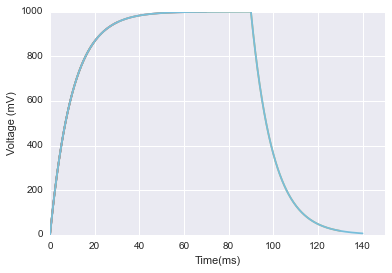

In [3]:
membrane()

Let's see what the maximum voltage of the membrane is by not turning the current off.

C = 0.100 nF
R = 100.000 M ohms
tau = 10.000 ms (Theoretical)
tau = 10.000 ms (Experimental)


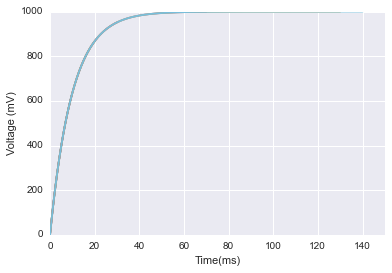

In [4]:
membrane(injectStop=False)

The maximum voltage seems to be **1000 mV**.

Let's see how the response looks by changing the parameters of the circuit now. First let's try increasing the resistance to $R_{new} = 5 R_{old} = 500 \text{ Mohms}$.

C = 0.100 nF
R = 500.000 M ohms
tau = 50.000 ms (Theoretical)
tau = 50.000 ms (Experimental)


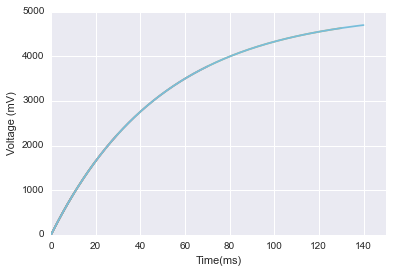

In [5]:
membrane(R=500,injectStop=False)

This increase in resistance seems to increase the rise time --  $\tau$ increases from 10ms to 50ms. Consequently, the membrane takes a longer time to reach a stable value. 

If we now decrease C by a factor of 10, does our system reacha stable value more quickly or slowly? 

C = 0.010 nF
R = 100.000 M ohms
tau = 1.000 ms (Theoretical)
tau = 1.000 ms (Experimental)


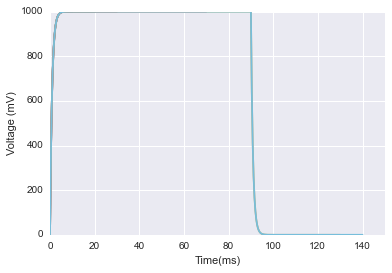

In [6]:
membrane(C=0.01)

The system reaches a stable voltage much sooner when we decrease the capacitance. This is an obvious result since
\begin{equation}
\tau = R C.
\end{equation}
So, of course, if we simultaneously increased the resistance by a factor of 10 and decreased the capacitance by a factor of 10, we should expect no change in $\tau$. This can be seen below.

C = 0.010 nF
R = 1000.000 M ohms
tau = 10.000 ms (Theoretical)
tau = 10.000 ms (Experimental)


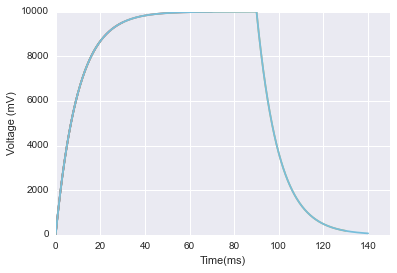

In [7]:
membrane(C=0.01,R=1000)

#V(t) for our simple RC circuit:

Given the differential equation for the passive membrane 

\begin{eqnarray}
\frac{dV}{dt} &=& -\frac{V}{RC} + \frac{I}{C} \tag{1}\\
\frac{dV}{dt} +\frac{V}{RC} &=& \frac{I}{C} 
\end{eqnarray}

with initial condition V(0) = 0.

This is a standard ODE that we can solve using an integrating factor as follows. Let $\mu(t) = e^{\int{1/RC} dt} = e^{t/RC}$ then multiply both sides of eq.(1) by $\mu(t)$. This gives

\begin{eqnarray}
e^{t/RC} \frac{dV}{dt} + e^{t/RC} \frac{V}{RC} &=& e^{t/RC} \frac{I}{C} \\
\frac{dV}{dt} e^{t/RC} + \frac{d}{dt}(e^{t/RC}) V  &=& e^{t/RC} \frac{I}{C} \\
\frac{d}{dt}\left(e^{t/RC}V(t) \right)  &=& e^{t/RC} \frac{I}{C} \text{ (reverse product rule)}\\
\end{eqnarray}
Integrate both sides with respect to t:

\begin{eqnarray}
\int \frac{d}{dt}\left(e^{t/RC}V(t) \right) dt  &=& \int e^{t/RC} \frac{I}{C} dt\\
e^{t/RC}V(t)  &=&  IR e^{t/RC} +C\\
V(t)  &=&  IR +C_1 e^-{t/RC}\\
\end{eqnarray}

Now we use our initial condition V(0) = 0 to find $C_1$

\begin{eqnarray}
0 &=&C_1 + IR\\
C_1&=& -IR
\end{eqnarray}



Therefore 

\begin{equation}
V(t) = IR(1-e^{-t /RC}) = V_{max}(1-e^{-t / \tau})
\end{equation}

#Integrate-and-fire model of a spiking neuron:

Now let's use the model of an integrate-and-fire neuron to examine the spiking properties of a single neuron. 

In [8]:
def IF_Neuron(I=1, C=1,R=40,tstop=200,noiseamp=0,calculateISI=True):
    # input current
    
    I = I # nA

    # capacitance and leak resistance
    C = C # nF
    R = R # M ohms

    # I & F implementation dV/dt = - V/RC + I/C
    # Using h = 1 ms step size, Euler method

    V = 0
    tstop = 200
    abs_ref = 5 # absolute refractory period 
    ref = 0 # absolute refractory period counter
    V_trace = []  # voltage trace for plotting
    V_th = 10 # spike threshold
    spiketimes = [] # list of spike times

    # input current
    noiseamp = noiseamp # amplitude of added noise
    I += noiseamp*np.random.normal(0, 1, (tstop,)) # nA; Gaussian noise

    for t in range(tstop):

        if not ref:
            V = V - (V/(R*C)) + (I[t]/C)
        else:
            ref -= 1
            V = 0.2 * V_th # reset voltage

        if V > V_th:
            V = 50 # emit spike
            ref = abs_ref # set refractory counter

        V_trace += [V]

    f=plt.figure()
    plt.subplot(1,2,1)
    plt.plot(V_trace)
    plt.xlabel('Time (ms)')
    plt.ylabel('Voltage (mV)')
    
    if calculateISI is True:
    #find at which times 
        spiketimes = [num for num,voltage in enumerate(V_trace) if voltage == np.max(V_trace)]

        plt.subplot(1,2,2)
        plt.hist(np.diff(spiketimes))
        plt.xlabel('Interspike interval (ms)')
        plt.ylabel('Count')
        plt.tight_layout()
    return V_trace

With no noise, we get a very clean response, with no variance in interspike intervals.

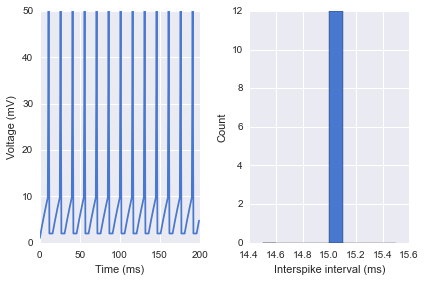

In [9]:
_=IF_Neuron()

Through trial and error, we can find that the smallest current required to ellicit a spike is 250 pA (to the nearest 10 pA).

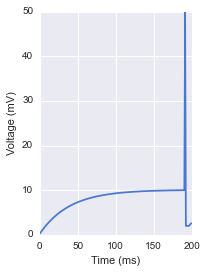

In [10]:
_=IF_Neuron(I=0.252,calculateISI=False)

To find the maximum firing rate, all we need to do is inject enough current such that the neuron cannot increase its firing rate, then calculate how many spikes fire within our time window that we are "recording" in.

Maximum firing rate: 170 Hz


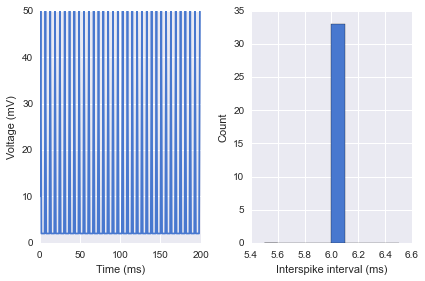

In [11]:
V_trace=IF_Neuron(I=10) #inject a ton of current

FR = len([num for num,voltage in enumerate(V_trace) if voltage ==np.max(V_trace)])/0.2
print(("Maximum firing rate: {:.0f} Hz").format(FR))

#Effects of noise on integrate-and-fire neuron:
Now we can see the effect of noise on the signal. As we increase the noise amplitude, what happens to the interspike interval?

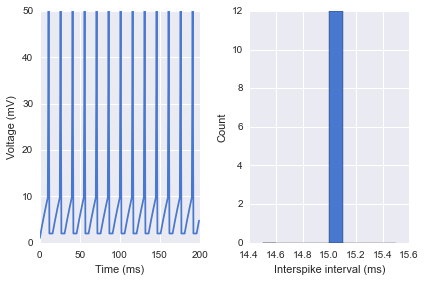

In [12]:
_=IF_Neuron(noiseamp=0)

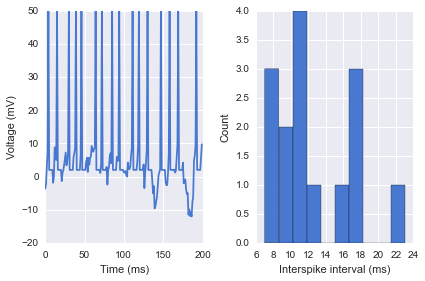

In [13]:
_=IF_Neuron(noiseamp=3)

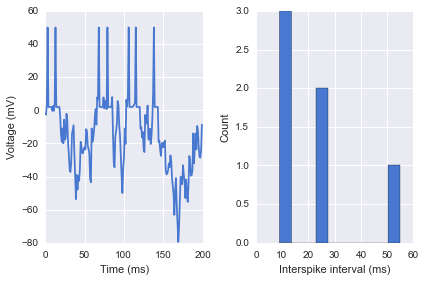

In [14]:
_=IF_Neuron(noiseamp=9) 

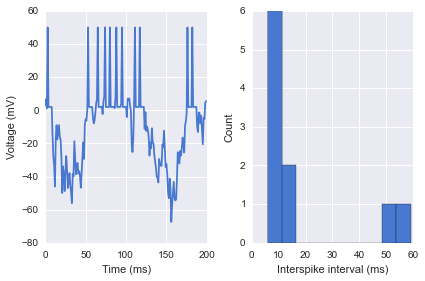

In [15]:
_=IF_Neuron(noiseamp=10)

We see that as the noise amplitude increases, the interspike interval decreases up to a certain point (but never zero, of course due to the absolute refractory period of the neuron), then resembles an exponential distribution as we increase the noise amplitude further.